In [3]:
%pip install tensorflow

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl (2.9 MB)
  Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl (7.7 kB)
  Using cached grpcio-1.74.0-cp310-cp310-win_amd64.whl (4.5 MB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wrapt-1.17.2-cp310-cp310-win_amd64.whl (38 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached requests-2.32.4-py3-none-any.whl (64 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl (434 kB)
  Using cached ml_dtypes-0.5.3-cp310-cp310-win_amd64.whl (206 

In [4]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [5]:
import os
from PIL import Image

# Define paths
flip_dir = os.path.join('images', 'training', 'flip')
notflip_dir = os.path.join('images', 'training', 'notflip')

# Load images for 'flip'
flip_images = []
for filename in os.listdir(flip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(flip_dir, filename)
        img = Image.open(img_path)
        flip_images.append(img)

# Load images for 'notflip'
notflip_images = []
for filename in os.listdir(notflip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(notflip_dir, filename)
        img = Image.open(img_path)
        notflip_images.append(img)

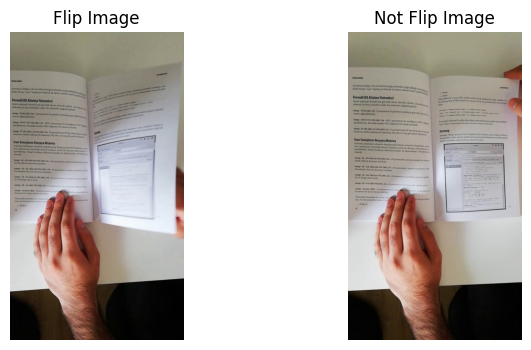

In [6]:
# Display one image from each category
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(flip_images[0])
plt.title('Flip Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(notflip_images[0])
plt.title('Not Flip Image')
plt.axis('off')

plt.show()

In [9]:
from random import shuffle

# Create labeled datasets
flip_dataset = [(img, 1) for img in flip_images]
notflip_dataset = [(img, 0) for img in notflip_images]

# Combine and shuffle
combined_dataset = flip_dataset + notflip_dataset
shuffle(combined_dataset)

In [10]:
combined_dataset[:5]  # Display the first 5 entries of the combined dataset

[(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 1),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 1),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0)]

In [11]:
X = [img for img, label in combined_dataset]
y = [label for img, label in combined_dataset]